In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from src.eval.eval import finetune_evaluate, finetune_evaluate_base
from src.models.mae_vit_regressor import mae_vit_base_patch16
from src.datas import transforms
from src.datas.dataloader import get_dataloader

In [2]:
class DeNormalize(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, x):
        self.mean = self.mean.to(x.device)
        self.std = self.std.to(x.device)
        return self.std * x + self.mean

In [121]:
target = 'TOC'
weights = f'results/scratch-{target}-info_train_1500.csv-epochs-100-blr-1e-4/model.ckpt'

In [122]:
criterion = torch.nn.MSELoss()
device = torch.device('cuda')

annotation_file = f'data/finetune/{target}%/train/info.csv'
target_mean = torch.load(f"src/datas/xpt_{target}_target_mean.pth")
target_std = torch.load(f"src/datas/xpt_{target}_target_std.pth")
target_transform = transforms.Normalize(target_mean, target_std)
reverse_pred = DeNormalize(target_mean, target_std)

model = mae_vit_base_patch16(pretrained=True,
                                weights=weights).to(device)

dataloader = get_dataloader(ispretrain=False,
                            annotations_file=annotation_file,
                            input_dir=f"data/finetune/{target}%/train",
                            batch_size=1,
                            transform=transforms.InstanceNorm(),
                            num_workers=8)
dataloader = dataloader['val']

In [123]:
points = []
model.eval()  # turn on evaluation mode

for batch in dataloader:
    samples = batch["spe"].to(device, non_blocking=True, dtype=torch.float)
    targets = batch["target"].to(
        device, non_blocking=True, dtype=torch.float)

    with torch.no_grad():
        preds = model(samples)
        if reverse_pred:
            preds = reverse_pred(preds)
        points.append([targets.squeeze().cpu().item(), preds.squeeze().cpu().item()])

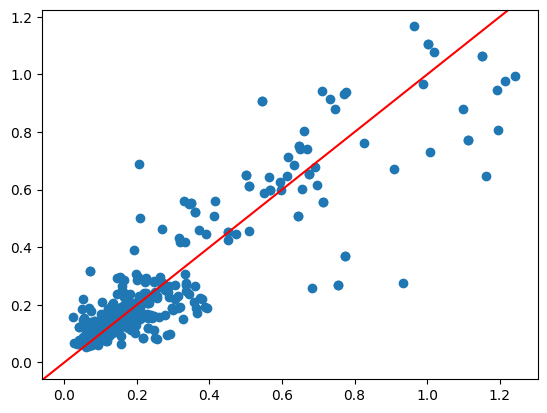

In [124]:
import numpy as np
from matplotlib import pyplot as plt

points_np = np.array(points)
fig, ax = plt.subplots()
ax.axline((0, 0), slope=1, color='red')
ax.scatter(x=points_np[:,0], y=points_np[:,1])
plt.show()